In [96]:
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib.pyplot as plt
from neurodsp.sim import sim_powerlaw
from neurodsp.spectral import compute_spectrum

import sys, os
sys.path.append('../')
from galaxybrain.plot_utils import rc_style, pltlabel
from galaxybrain.ramsey import pca, fooofy

rc_style(font_size=14)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fractional Brownian motion (fBm) simulation

simulated using [`neurodsp.sim.sim_powerlaw`](https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.sim.sim_powerlaw.html#neurodsp.sim.sim_powerlaw)
```python
Signature: sim_powerlaw(n_seconds, fs, exponent=-2.0, f_range=None, **filter_kwargs)
Docstring:
```
```
Simulate a power law time series, with a specified exponent.

Parameters
----------
n_seconds : float
    Simulation time, in seconds.
fs : float
    Sampling rate of simulated signal, in Hz.
exponent : float
    Desired power-law exponent, of the form P(f)=f^exponent.
f_range : list of [float, float] or None, optional
    Frequency range to filter simulated data, as [f_lo, f_hi], in Hz.
**filter_kwargs : kwargs, optional
    Keyword arguments to pass to `filter_signal`.

Returns
-------
sig: 1d array
    Time-series with the desired power law exponent.
```

## Increasing fractal dimension ($\alpha$) makes dynamics more fractal

$\alpha = 2H + 1$, where $H$ is the hurst exponent

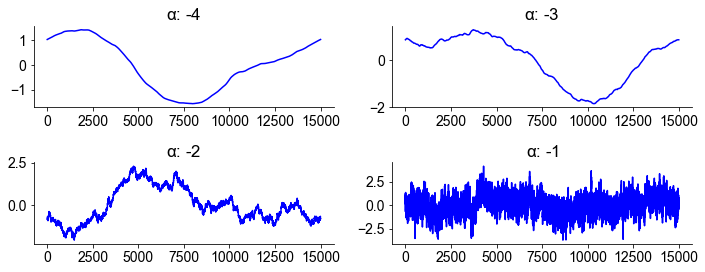

In [15]:
plt.figure(figsize=(10,4))
for n_i, a in enumerate(range(-4,0)):
    signal = sim_powerlaw(n_seconds=30, fs=500, exponent=a)
    plt.subplot(2,2,n_i+1)
    plt.plot(signal, color='b')
    plt.title(r'$\alpha$: {}'.format(a))
plt.tight_layout()

### PCA on multiple "electrodes"





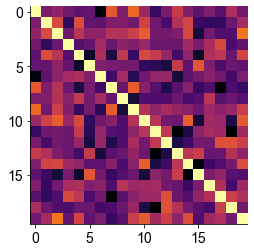

In [25]:
exp, num = -3, 20
signals = []
for i in enumerate(range(num)):
    signals.append(sim_powerlaw(n_seconds=30, fs=500, f_range = [0.1,100], exponent=exp))

correlations = np.corrcoef(np.array(signals))

plt.figure()
plt.imshow(correlations, 'inferno')
plt.show()

# Calculate fBm spatial & temporal spectra over exponent range

In [94]:
def sim_and_fit(exponents, sum_sig, num=100, f_range=None):
    """
    Iterates over list of exponents, simulates an fBm signal
    and calculate spatial & temporal spectra, and fits exponent
    """
    fs=500; nperseg=fs; noverlap=fs/2 #; freqs = np.fft.rfftfreq(nperseg); 
    pc_dims = np.arange(1,num+1)
    pca_results = []
    fft_results = []
    slopes = []
    for exp in exponents:
        sig = np.array([sim_powerlaw(60, fs, exp) for n in range(num)]) # sample of num signals
        evals = pca(sig.T, num) # transpose shape
        pca_results.append(evals)
        
        if sum_sig:
            sig = np.array(sig).sum(axis = 0) # now one time series
        freqs, spec = compute_spectrum(sig, fs, nperseg=nperseg, noverlap=noverlap)
        fft_results.append(spec)
        if not sum_sig:
            spec = spec.mean(0)
        slopes.append( (fooofy(pc_dims, evals, None, group = False)[0], 
                        fooofy(freqs, spec, f_range, group = False)[0]) )
        
    return tuple(map(np.array, (slopes, pca_results, fft_results)))

exponents = np.around(np.arange(-4,0.2,0.2),1) #no sci notation
slopes, pca_results, fft_results = sim_and_fit(exponents, sum_sig = False)
slopes2, pca_results2, fft_results2 = sim_and_fit(exponents, sum_sig = True)

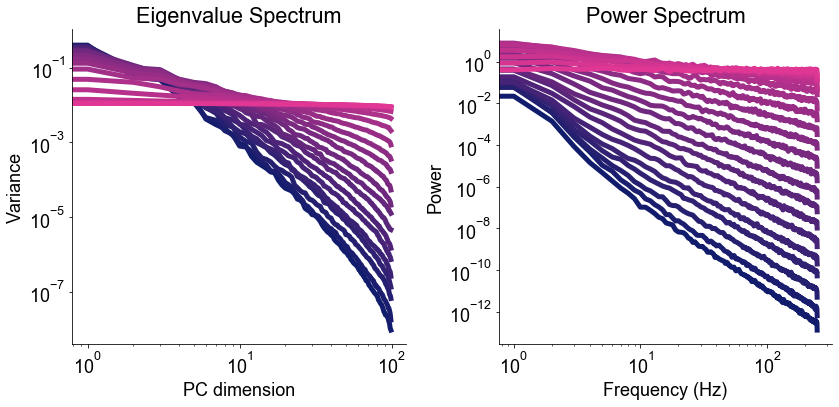

In [95]:
rc_style(font_size=18)
colorcycler(['#111d6c', '#e03694'], exponents.shape[0])
# e spec
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.loglog(pca_results2.T, linewidth=5) 
pltlabel('Eigenvalue Spectrum', 'PC dimension', 'Variance')
## PSD
plt.subplot(1,2,2)
#plt.loglog(fft_results.mean(0), linewidth=5, color=cmap[i]) #in non summing case
plt.loglog(fft_results2.T, linewidth=5)
pltlabel('Power Spectrum','Frequency (Hz)', 'Power')
plt.tight_layout()   
plt.show()

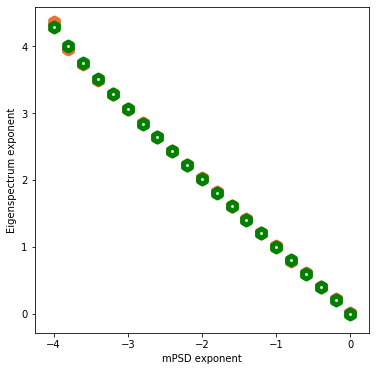

In [10]:
x, y = [], []
x2, y2 = [], []

for i in slopes:
    x.append(slopes2[i][0]) #Espec exps
    y.append(slopes2[i][1]) #PSD exps | just input k for ground truth
    x2.append(slopes[i][0])
    y2.append(slopes[i][1])
y = [abs(float(n)) for n in y] #converting to positive numbers (this is the exponent).  Using abs because they are all negative
y2 = [abs(float(n)) for n in y2]

plt.figure(figsize = (6,6))

sc = plt.scatter(slopes2, y, marker = 'h', c = 'white', edgecolors = '#eb7134', s= 80, linewidths = 5)
sc = plt.scatter(slopes2, y2, marker = 'h', c = 'white', edgecolors = 'green', s= 80, linewidths = 5)
pltlabel(None, 'Eigenspectrum exponent', 'PSD exponent') 
plt.locator_params(axis='y', tight=True, nbins=8); #plt.locator_params(which='x', tight=True, nbins=8)

plt.show()

# Gaussian sim to check PC spectrum drop off

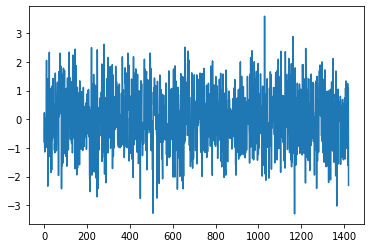

In [3]:
y = np.random.normal(size=1462)
burn_in = 20
plt.plot(y[burn_in:-burn_in])

## todo: Manual fBm?